In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019/valid.csv
/kaggle/input/aptos2019/test.csv
/kaggle/input/aptos2019/train_1.csv
/kaggle/input/aptos2019/val_images/val_images/17f6c7072f61.png
/kaggle/input/aptos2019/val_images/val_images/0243404e8a00.png
/kaggle/input/aptos2019/val_images/val_images/0083ee8054ee.png
/kaggle/input/aptos2019/val_images/val_images/0ac436400db4.png
/kaggle/input/aptos2019/val_images/val_images/0d0a21fd354f.png
/kaggle/input/aptos2019/val_images/val_images/02da652c74b8.png
/kaggle/input/aptos2019/val_images/val_images/15e96e848b46.png
/kaggle/input/aptos2019/val_images/val_images/059bc89df7f4.png
/kaggle/input/aptos2019/val_images/val_images/04d029cfb612.png
/kaggle/input/aptos2019/val_images/val_images/08752092140d.png
/kaggle/input/aptos2019/val_images/val_images/0ef4c61dc056.png
/kaggle/input/aptos2019/val_images/val_images/1a7e3356b39c.png
/kaggle/input/aptos2019/val_images/val_images/06be1092a062.png
/kaggle/input/aptos2019/val_images/val_images/03a7f4a5786f.png
/kaggle/input/a

# Part 1

In [2]:
import os
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

epoch = 10

# --- CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths for datasets
train_img_dir_dr = '/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/DeepDRiD/train'
val_img_dir_dr = '/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/DeepDRiD/val'
test_img_dir_dr = '/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/DeepDRiD/test'

train_csv_dr = '/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/DeepDRiD/train.csv'
val_csv_dr = '/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/DeepDRiD/val.csv'
test_csv_dr = '/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/DeepDRiD/test.csv'

model_save_paths = {
    "resnet18": "./best_model_resnet18.pth",
    "resnet34": "./best_model_resnet34.pth",
    "densenet121": "./best_model_densenet121.pth"
}

# --- DATASET CLASS ---
class DiabeticRetinopathyDataset(Dataset):
    """
    Single unified Dataset class that can handle:
    - APTOS format (id_code, diagnosis)
    - DeepDRiD format (img_path, patient_DR_Level)
    - or any CSV with 'id_code' or 'img_path' + label col.
    """
    def __init__(self, csv_file, img_dir, transform=None, is_test=False):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Identify which column we have
        if 'id_code' in self.data.columns:  
            # APTOS
            img_path = os.path.join(self.img_dir, self.data.iloc[idx]['id_code'] + '.png')
            image_id = self.data.iloc[idx]['id_code']
        elif 'img_path' in self.data.columns:  
            # DeepDRiD
            img_path = os.path.join(self.img_dir, self.data.iloc[idx]['img_path'])
            # Use 'image_id' if present; otherwise fall back to index
            image_id = self.data.iloc[idx].get('image_id', idx)
        else:
            raise ValueError("Invalid dataset format: neither 'id_code' nor 'img_path' found.")
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # If test set, we have no label
        if self.is_test:
            # Return both image and ID so we can write them out in submission
            return image, image_id

        # Otherwise, get label
        if 'diagnosis' in self.data.columns:  
            # APTOS
            label = int(self.data.iloc[idx]['diagnosis'])
        elif 'patient_DR_Level' in self.data.columns:  
            # DeepDRiD
            label = int(self.data.iloc[idx]['patient_DR_Level'])
        else:
            raise ValueError("Invalid dataset format: No label column found.")
        
        return image, label

# --- DATA AUGMENTATION AND TRANSFORMS ---
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- LOAD DATASETS (DeepDRiD) ---
train_dataset = DiabeticRetinopathyDataset(train_csv_dr, train_img_dir_dr,
                                           transform=train_transform, is_test=False)
val_dataset = DiabeticRetinopathyDataset(val_csv_dr, val_img_dir_dr,
                                         transform=val_test_transform, is_test=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- LOAD PRETRAINED MODEL ---
def load_pretrained_model(model_name, num_classes=5):
    """
    Loads a pretrained model. 
    Options:
      - "resnet18": standard ResNet18
      - "resnet18_cbam": ResNet18 with CBAM
    """
    """
    Loads a pretrained model and replaces the FC layer for the DeepDRiD dataset.
    Args:
        model_name (str): Name of the pretrained model (e.g., 'resnet18', 'resnet34').
    Returns:
        model (torch.nn.Module): The pretrained model with customized FC layers.
    """
    pretrained_paths = {
        "resnet18": "/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/pretrained_DR_resize/pretrained/resnet18.pth",
        "resnet34": "/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/pretrained_DR_resize/pretrained/resnet34.pth",
        "vgg16": "/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/pretrained_DR_resize/pretrained/vgg16.pth",
        "densenet121": "/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/pretrained_DR_resize/pretrained/densenet121.pth",
        "efficientnet_b0": "/kaggle/input/oulu-deep-learning-projects/521153S-3005-final-project/pretrained_DR_resize/pretrained/efficientnet_b0.pth"
    }
    
    if model_name == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        # # Replace final FC with custom classifier
        # model.fc = nn.Sequential(
        #     nn.Linear(model.fc.in_features, 512),
        #     nn.ReLU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(512, 5)  # 5 DR levels
        # )
    elif model_name == "resnet18_cbam":
        # ResNet18 + CBAM
        # model = ResNet18WithCBAM(num_classes=5, pretrained=True)
        model = ResNet18WithCBAM(num_classes=num_classes, pretrained=True)
        # skip loading from pretrained_paths
        return model.to(device)
    elif model_name == "resnet34":
        model = models.resnet34(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "densenet121":
        model = models.densenet121(weights="IMAGENET1K_V1")
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == "vgg16":
        model = models.vgg16()
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0()
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        raise ValueError(f"Unsupported model: {model_name}")
        
    pretrained_path = pretrained_paths[model_name]
    model.load_state_dict(torch.load(pretrained_path), strict=False)
    return model.to(device)

# --- TRAINING FUNCTION ---
def train_and_validate(model, 
                       train_loader, 
                       val_loader, 
                       criterion, 
                       optimizer, 
                       save_path, 
                       num_epochs=5, 
                       freeze_layers=False):
    """
    Train a model and save the best weights based on validation Kappa.
    
    Args:
        model (torch.nn.Module): Model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (loss): Loss function.
        optimizer (torch.optim): Optimizer.
        save_path (str): Path to save the best model.
        num_epochs (int): Number of epochs.
        freeze_layers (bool): If True, freeze all layers except the final one.
        
    Returns:
        best_kappa (float): The best validation Kappa over all epochs.
    """
    # (FIXED) Optionally freeze layers except final
    if freeze_layers:
        # Example for ResNet-based models:
        for name, param in model.named_parameters():
            if "fc" not in name:
                param.requires_grad = False

    best_kappa = -1
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_preds, train_labels = 0.0, [], []

        with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                train_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                train_labels.extend(labels.cpu().numpy())
                pbar.update(1)

        # train_loss /= len(train_loader.dataset)
        train_kappa = cohen_kappa_score(train_labels, train_preds)
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss/len(train_loader.dataset):.4f} | Train Kappa: {train_kappa:.4f}")

        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # val_loss /= len(val_loader.dataset)
        val_kappa = cohen_kappa_score(val_labels, val_preds)
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss/len(train_loader.dataset):.4f}, "
              f"Val Loss: {val_loss/len(val_loader.dataset):.4f}, "
              f"Val Kappa: {val_kappa:.4f}")

        # Save best model
        if val_kappa > best_kappa:
            best_kappa = val_kappa
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with val_kappa = {best_kappa:.4f}")

    return best_kappa

# --- MAIN SCRIPT FOR COMPARISON (DeepDRiD) ---
models_to_train = ["resnet18", "resnet34", "densenet121"]
criterion = nn.CrossEntropyLoss()
kappa_scores = {}

for model_name in models_to_train:
    print(f"\nTraining {model_name}...")
    model = load_pretrained_model(model_name)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    save_path = model_save_paths[model_name]
    
    # (FIXED) Store best_kappa separately
    best_kappa = train_and_validate(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        save_path=save_path, 
        num_epochs=epoch
    )
    kappa_scores[model_name] = best_kappa

print("\n--- Model Kappa Scores ---")
for model_name, kappa in kappa_scores.items():
    print(f"{model_name}: {kappa:.4f}")



Training resnet18...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]
<ipython-input-2-acd7dafff650>:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loade

[Epoch 1] Train Loss: 1.2327 | Train Kappa: 0.3574


Validating: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 1/10, Train Loss: 1.2327, Val Loss: 1.1587, Val Kappa: 0.3842
Best model saved with val_kappa = 0.3842


Training Epoch 2/10: 100%|██████████| 38/38 [00:15<00:00,  2.40batch/s]


[Epoch 2] Train Loss: 1.1189 | Train Kappa: 0.3843


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


Epoch 2/10, Train Loss: 1.1189, Val Loss: 0.9635, Val Kappa: 0.4903
Best model saved with val_kappa = 0.4903


Training Epoch 3/10: 100%|██████████| 38/38 [00:15<00:00,  2.43batch/s]


[Epoch 3] Train Loss: 1.0481 | Train Kappa: 0.4306


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Epoch 3/10, Train Loss: 1.0481, Val Loss: 0.9319, Val Kappa: 0.5061
Best model saved with val_kappa = 0.5061


Training Epoch 4/10: 100%|██████████| 38/38 [00:15<00:00,  2.46batch/s]


[Epoch 4] Train Loss: 1.0463 | Train Kappa: 0.4309


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch 4/10, Train Loss: 1.0463, Val Loss: 0.8736, Val Kappa: 0.5706
Best model saved with val_kappa = 0.5706


Training Epoch 5/10: 100%|██████████| 38/38 [00:15<00:00,  2.47batch/s]


[Epoch 5] Train Loss: 1.0521 | Train Kappa: 0.4135


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.65it/s]


Epoch 5/10, Train Loss: 1.0521, Val Loss: 1.0344, Val Kappa: 0.4827


Training Epoch 6/10: 100%|██████████| 38/38 [00:15<00:00,  2.50batch/s]


[Epoch 6] Train Loss: 1.0126 | Train Kappa: 0.4750


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.37it/s]


Epoch 6/10, Train Loss: 1.0126, Val Loss: 0.8722, Val Kappa: 0.5243


Training Epoch 7/10: 100%|██████████| 38/38 [00:14<00:00,  2.54batch/s]


[Epoch 7] Train Loss: 0.9987 | Train Kappa: 0.4822


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch 7/10, Train Loss: 0.9987, Val Loss: 1.0078, Val Kappa: 0.4563


Training Epoch 8/10: 100%|██████████| 38/38 [00:15<00:00,  2.51batch/s]


[Epoch 8] Train Loss: 1.0034 | Train Kappa: 0.4380


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.94it/s]


Epoch 8/10, Train Loss: 1.0034, Val Loss: 0.9552, Val Kappa: 0.5079


Training Epoch 9/10: 100%|██████████| 38/38 [00:15<00:00,  2.49batch/s]


[Epoch 9] Train Loss: 0.9704 | Train Kappa: 0.4852


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Epoch 9/10, Train Loss: 0.9704, Val Loss: 0.9423, Val Kappa: 0.5199


Training Epoch 10/10: 100%|██████████| 38/38 [00:15<00:00,  2.51batch/s]


[Epoch 10] Train Loss: 0.9292 | Train Kappa: 0.5298


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.68it/s]


Epoch 10/10, Train Loss: 0.9292, Val Loss: 1.0818, Val Kappa: 0.4568

Training resnet34...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 200MB/s]
<ipython-input-2-acd7dafff650>:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loade

[Epoch 1] Train Loss: 1.2331 | Train Kappa: 0.3317


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.27it/s]


Epoch 1/10, Train Loss: 1.2331, Val Loss: 1.1356, Val Kappa: 0.4448
Best model saved with val_kappa = 0.4448


Training Epoch 2/10: 100%|██████████| 38/38 [00:16<00:00,  2.28batch/s]


[Epoch 2] Train Loss: 1.1455 | Train Kappa: 0.3834


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


Epoch 2/10, Train Loss: 1.1455, Val Loss: 1.1362, Val Kappa: 0.4235


Training Epoch 3/10: 100%|██████████| 38/38 [00:16<00:00,  2.28batch/s]


[Epoch 3] Train Loss: 1.0594 | Train Kappa: 0.4327


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 3/10, Train Loss: 1.0594, Val Loss: 1.0574, Val Kappa: 0.4312


Training Epoch 4/10: 100%|██████████| 38/38 [00:16<00:00,  2.35batch/s]


[Epoch 4] Train Loss: 1.0778 | Train Kappa: 0.4178


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.26it/s]


Epoch 4/10, Train Loss: 1.0778, Val Loss: 1.0954, Val Kappa: 0.4671
Best model saved with val_kappa = 0.4671


Training Epoch 5/10: 100%|██████████| 38/38 [00:16<00:00,  2.30batch/s]


[Epoch 5] Train Loss: 1.0492 | Train Kappa: 0.4435


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.27it/s]


Epoch 5/10, Train Loss: 1.0492, Val Loss: 0.9405, Val Kappa: 0.4773
Best model saved with val_kappa = 0.4773


Training Epoch 6/10: 100%|██████████| 38/38 [00:16<00:00,  2.35batch/s]


[Epoch 6] Train Loss: 1.0304 | Train Kappa: 0.4471


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Epoch 6/10, Train Loss: 1.0304, Val Loss: 0.9271, Val Kappa: 0.4971
Best model saved with val_kappa = 0.4971


Training Epoch 7/10: 100%|██████████| 38/38 [00:16<00:00,  2.30batch/s]


[Epoch 7] Train Loss: 1.0429 | Train Kappa: 0.4361


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Epoch 7/10, Train Loss: 1.0429, Val Loss: 1.2200, Val Kappa: 0.3540


Training Epoch 8/10: 100%|██████████| 38/38 [00:16<00:00,  2.29batch/s]


[Epoch 8] Train Loss: 1.0006 | Train Kappa: 0.4660


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.37it/s]


Epoch 8/10, Train Loss: 1.0006, Val Loss: 1.0179, Val Kappa: 0.4592


Training Epoch 9/10: 100%|██████████| 38/38 [00:16<00:00,  2.34batch/s]


[Epoch 9] Train Loss: 1.0058 | Train Kappa: 0.4901


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Epoch 9/10, Train Loss: 1.0058, Val Loss: 0.9332, Val Kappa: 0.5066
Best model saved with val_kappa = 0.5066


Training Epoch 10/10: 100%|██████████| 38/38 [00:16<00:00,  2.32batch/s]


[Epoch 10] Train Loss: 0.9454 | Train Kappa: 0.4773


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.44it/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Epoch 10/10, Train Loss: 0.9454, Val Loss: 1.1166, Val Kappa: 0.3795

Training densenet121...


100%|██████████| 30.8M/30.8M [00:00<00:00, 165MB/s]
<ipython-input-2-acd7dafff650>:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretra

[Epoch 1] Train Loss: 1.2155 | Train Kappa: 0.3732


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


Epoch 1/10, Train Loss: 1.2155, Val Loss: 1.2205, Val Kappa: 0.3824
Best model saved with val_kappa = 0.3824


Training Epoch 2/10: 100%|██████████| 38/38 [00:19<00:00,  1.92batch/s]


[Epoch 2] Train Loss: 1.0881 | Train Kappa: 0.4262


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch 2/10, Train Loss: 1.0881, Val Loss: 1.1906, Val Kappa: 0.4228
Best model saved with val_kappa = 0.4228


Training Epoch 3/10: 100%|██████████| 38/38 [00:19<00:00,  1.93batch/s]


[Epoch 3] Train Loss: 1.0355 | Train Kappa: 0.4532


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.85it/s]


Epoch 3/10, Train Loss: 1.0355, Val Loss: 1.0773, Val Kappa: 0.4468
Best model saved with val_kappa = 0.4468


Training Epoch 4/10: 100%|██████████| 38/38 [00:19<00:00,  1.93batch/s]


[Epoch 4] Train Loss: 1.0727 | Train Kappa: 0.4113


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.77it/s]


Epoch 4/10, Train Loss: 1.0727, Val Loss: 0.9038, Val Kappa: 0.5368
Best model saved with val_kappa = 0.5368


Training Epoch 5/10: 100%|██████████| 38/38 [00:19<00:00,  1.93batch/s]


[Epoch 5] Train Loss: 1.0103 | Train Kappa: 0.4602


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.82it/s]


Epoch 5/10, Train Loss: 1.0103, Val Loss: 0.9523, Val Kappa: 0.5061


Training Epoch 6/10: 100%|██████████| 38/38 [00:19<00:00,  1.91batch/s]


[Epoch 6] Train Loss: 0.9578 | Train Kappa: 0.4788


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch 6/10, Train Loss: 0.9578, Val Loss: 0.9464, Val Kappa: 0.5240


Training Epoch 7/10: 100%|██████████| 38/38 [00:19<00:00,  1.92batch/s]


[Epoch 7] Train Loss: 0.9564 | Train Kappa: 0.4750


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.67it/s]


Epoch 7/10, Train Loss: 0.9564, Val Loss: 1.0826, Val Kappa: 0.4419


Training Epoch 8/10: 100%|██████████| 38/38 [00:19<00:00,  1.92batch/s]


[Epoch 8] Train Loss: 0.9803 | Train Kappa: 0.4821


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


Epoch 8/10, Train Loss: 0.9803, Val Loss: 1.1494, Val Kappa: 0.3467


Training Epoch 9/10: 100%|██████████| 38/38 [00:20<00:00,  1.87batch/s]


[Epoch 9] Train Loss: 0.9239 | Train Kappa: 0.5130


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.57it/s]


Epoch 9/10, Train Loss: 0.9239, Val Loss: 0.8899, Val Kappa: 0.5638
Best model saved with val_kappa = 0.5638


Training Epoch 10/10: 100%|██████████| 38/38 [00:20<00:00,  1.89batch/s]


[Epoch 10] Train Loss: 0.9216 | Train Kappa: 0.5011


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.61it/s]

Epoch 10/10, Train Loss: 0.9216, Val Loss: 0.9935, Val Kappa: 0.5535

--- Model Kappa Scores ---
resnet18: 0.5706
resnet34: 0.5066
densenet121: 0.5638


# Part 2

In [3]:
# Paths for APTOS
train_img_dir_aptos = '/kaggle/input/aptos2019/train_images/train_images'
val_img_dir_aptos   = '/kaggle/input/aptos2019/val_images/val_images'
test_img_dir_aptos  = '/kaggle/input/aptos2019/test_images/test_images'

train_csv_aptos = '/kaggle/input/aptos2019/train_1.csv'
val_csv_aptos   = '/kaggle/input/aptos2019/valid.csv'
test_csv_aptos  = '/kaggle/input/aptos2019/test.csv'

model_save_path_stage1 = './model_stage1.pth'
model_save_path_stage2 = './model_stage2.pth'


# --- LOAD DATASETS (APTOS) ---
train_dataset_aptos = DiabeticRetinopathyDataset(
    train_csv_aptos, 
    train_img_dir_aptos, 
    transform=train_transform
)

val_dataset_aptos = DiabeticRetinopathyDataset(
    val_csv_aptos, 
    val_img_dir_aptos, 
    transform=val_test_transform
)

train_loader_aptos = DataLoader(train_dataset_aptos, batch_size=32, shuffle=True)
val_loader_aptos   = DataLoader(val_dataset_aptos, batch_size=32, shuffle=False)


# --- TESTING FUNCTION ---
def test_model(model, test_csv, test_img_dir, output_file, is_aptos=True):
    """
    Testing and submission generation for both APTOS and DeepDRiD datasets.

    Args:
        model (nn.Module): Trained model.
        test_csv (str): Path to test CSV file.
        test_img_dir (str): Path to test images directory.
        output_file (str): Output CSV file path for submission.
        is_aptos (bool): True if dataset is APTOS, else DeepDRiD.
    """
    # (FIXED) Use val_test_transform or a new transform for inference
    test_dataset = DiabeticRetinopathyDataset(
        test_csv,
        test_img_dir,
        transform=val_test_transform, 
        is_test=True
    )
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model.eval()
    predictions, ids = [], []

    with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, image_ids in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1).cpu().numpy()
                predictions.extend(preds)
                ids.extend(image_ids)
                pbar.update(1)

    # Construct submission
    # Use the right column names based on is_aptos
    if is_aptos:
        submission = pd.DataFrame({'id_code': ids, 'diagnosis': predictions})
    else:
        submission = pd.DataFrame({'ID': ids, 'TARGET': predictions})
    
    submission.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")


# --- STAGE 1: TRAIN ON APTOS DATASET ---
model_stage1 = load_pretrained_model("resnet18")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_stage1.parameters(), lr=0.001)

print("\n--- Stage 1: Training on APTOS Dataset ---")
best_kappa_aptos = train_and_validate(
    model_stage1,
    train_loader_aptos,
    val_loader_aptos,
    criterion,
    optimizer,
    save_path=model_save_path_stage1,
    num_epochs=epoch
)

# (FIXED) Load the best weights from Stage 1
model_stage1.load_state_dict(torch.load(model_save_path_stage1))

# --- STAGE 2: FINE-TUNE ON DEEPDRiD DATASET ---
# (FIXED) We'll reuse the same model_stage1 instance, but freeze layers (if desired)
print("\n--- Stage 2: Fine-tuning on DeepDRiD Dataset ---")

# Freeze all but final layer, then re-init the optimizer
optimizer = optim.Adam(model_stage1.fc.parameters(), lr=0.0001)  # Fine-tune final layer only

best_kappa_deepdrid = train_and_validate(
    model_stage1,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    save_path=model_save_path_stage2,
    num_epochs=epoch,
    freeze_layers=True  # Now the function can handle freezing
)

# (FIXED) Load the best weights from Stage 2
model_stage1.load_state_dict(torch.load(model_save_path_stage2))

# --- TESTING ---
print("\n--- Testing Stage 1 model on APTOS Test Set ---")
test_model(model_stage1, test_csv_aptos, test_img_dir_aptos,
           output_file="submission_stage1.csv", is_aptos=True)

print("\n--- Testing Stage 2 model on DeepDRiD Test Set ---")
test_model(model_stage1, test_csv_dr, test_img_dir_dr,
           output_file="submission_stage2.csv", is_aptos=False)

<ipython-input-2-acd7dafff650>:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_path), strict=False)



--- Stage 1: Training on APTOS Dataset ---


Training Epoch 1/10: 100%|██████████| 92/92 [07:51<00:00,  5.13s/batch]


[Epoch 1] Train Loss: 0.8358 | Train Kappa: 0.5129


Validating: 100%|██████████| 12/12 [00:55<00:00,  4.59s/it]


Epoch 1/10, Train Loss: 0.8358, Val Loss: 0.6583, Val Kappa: 0.5746
Best model saved with val_kappa = 0.5746


Training Epoch 2/10: 100%|██████████| 92/92 [06:33<00:00,  4.27s/batch]


[Epoch 2] Train Loss: 0.7422 | Train Kappa: 0.5459


Validating: 100%|██████████| 12/12 [00:44<00:00,  3.70s/it]


Epoch 2/10, Train Loss: 0.7422, Val Loss: 0.7183, Val Kappa: 0.5904
Best model saved with val_kappa = 0.5904


Training Epoch 3/10: 100%|██████████| 92/92 [06:28<00:00,  4.22s/batch]


[Epoch 3] Train Loss: 0.7350 | Train Kappa: 0.5576


Validating: 100%|██████████| 12/12 [00:44<00:00,  3.68s/it]


Epoch 3/10, Train Loss: 0.7350, Val Loss: 0.6032, Val Kappa: 0.6222
Best model saved with val_kappa = 0.6222


Training Epoch 4/10: 100%|██████████| 92/92 [06:28<00:00,  4.22s/batch]


[Epoch 4] Train Loss: 0.7007 | Train Kappa: 0.5799


Validating: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 4/10, Train Loss: 0.7007, Val Loss: 0.6541, Val Kappa: 0.5648


Training Epoch 5/10: 100%|██████████| 92/92 [06:29<00:00,  4.23s/batch]


[Epoch 5] Train Loss: 0.6751 | Train Kappa: 0.5903


Validating: 100%|██████████| 12/12 [00:44<00:00,  3.68s/it]


Epoch 5/10, Train Loss: 0.6751, Val Loss: 0.6508, Val Kappa: 0.6175


Training Epoch 6/10: 100%|██████████| 92/92 [06:31<00:00,  4.26s/batch]


[Epoch 6] Train Loss: 0.6907 | Train Kappa: 0.5843


Validating: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 6/10, Train Loss: 0.6907, Val Loss: 0.6500, Val Kappa: 0.5976


Training Epoch 7/10: 100%|██████████| 92/92 [06:30<00:00,  4.25s/batch]


[Epoch 7] Train Loss: 0.6699 | Train Kappa: 0.5904


Validating: 100%|██████████| 12/12 [00:44<00:00,  3.71s/it]


Epoch 7/10, Train Loss: 0.6699, Val Loss: 0.6730, Val Kappa: 0.5900


Training Epoch 8/10: 100%|██████████| 92/92 [06:32<00:00,  4.27s/batch]


[Epoch 8] Train Loss: 0.6733 | Train Kappa: 0.5949


Validating: 100%|██████████| 12/12 [00:44<00:00,  3.71s/it]


Epoch 8/10, Train Loss: 0.6733, Val Loss: 0.6255, Val Kappa: 0.6083


Training Epoch 9/10: 100%|██████████| 92/92 [06:33<00:00,  4.27s/batch]


[Epoch 9] Train Loss: 0.6495 | Train Kappa: 0.5926


Validating: 100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


Epoch 9/10, Train Loss: 0.6495, Val Loss: 0.5870, Val Kappa: 0.6366
Best model saved with val_kappa = 0.6366


Training Epoch 10/10: 100%|██████████| 92/92 [06:30<00:00,  4.24s/batch]


[Epoch 10] Train Loss: 0.6623 | Train Kappa: 0.6128


Validating: 100%|██████████| 12/12 [00:44<00:00,  3.69s/it]
<ipython-input-3-e03753cb6f19>:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_stage1.load_state_dict(tor

Epoch 10/10, Train Loss: 0.6623, Val Loss: 0.5994, Val Kappa: 0.6222

--- Stage 2: Fine-tuning on DeepDRiD Dataset ---


Training Epoch 1/10: 100%|██████████| 38/38 [00:15<00:00,  2.47batch/s]


[Epoch 1] Train Loss: 1.9034 | Train Kappa: 0.1867


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.53it/s]


Epoch 1/10, Train Loss: 1.9034, Val Loss: 1.4864, Val Kappa: 0.2777
Best model saved with val_kappa = 0.2777


Training Epoch 2/10: 100%|██████████| 38/38 [00:13<00:00,  2.72batch/s]


[Epoch 2] Train Loss: 1.5677 | Train Kappa: 0.2104


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]


Epoch 2/10, Train Loss: 1.5677, Val Loss: 1.3910, Val Kappa: 0.3204
Best model saved with val_kappa = 0.3204


Training Epoch 3/10: 100%|██████████| 38/38 [00:13<00:00,  2.72batch/s]


[Epoch 3] Train Loss: 1.4637 | Train Kappa: 0.2233


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


Epoch 3/10, Train Loss: 1.4637, Val Loss: 1.3945, Val Kappa: 0.3169


Training Epoch 4/10: 100%|██████████| 38/38 [00:13<00:00,  2.79batch/s]


[Epoch 4] Train Loss: 1.4111 | Train Kappa: 0.2653


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.08it/s]


Epoch 4/10, Train Loss: 1.4111, Val Loss: 1.4018, Val Kappa: 0.3235
Best model saved with val_kappa = 0.3235


Training Epoch 5/10: 100%|██████████| 38/38 [00:13<00:00,  2.75batch/s]


[Epoch 5] Train Loss: 1.4135 | Train Kappa: 0.2604


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]


Epoch 5/10, Train Loss: 1.4135, Val Loss: 1.3643, Val Kappa: 0.3263
Best model saved with val_kappa = 0.3263


Training Epoch 6/10: 100%|██████████| 38/38 [00:13<00:00,  2.75batch/s]


[Epoch 6] Train Loss: 1.3750 | Train Kappa: 0.2745


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.95it/s]


Epoch 6/10, Train Loss: 1.3750, Val Loss: 1.3892, Val Kappa: 0.3119


Training Epoch 7/10: 100%|██████████| 38/38 [00:13<00:00,  2.80batch/s]


[Epoch 7] Train Loss: 1.3304 | Train Kappa: 0.2753


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.75it/s]


Epoch 7/10, Train Loss: 1.3304, Val Loss: 1.3537, Val Kappa: 0.3139


Training Epoch 8/10: 100%|██████████| 38/38 [00:13<00:00,  2.77batch/s]


[Epoch 8] Train Loss: 1.3803 | Train Kappa: 0.2529


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.15it/s]


Epoch 8/10, Train Loss: 1.3803, Val Loss: 1.3223, Val Kappa: 0.3219


Training Epoch 9/10: 100%|██████████| 38/38 [00:13<00:00,  2.75batch/s]


[Epoch 9] Train Loss: 1.3132 | Train Kappa: 0.2840


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Epoch 9/10, Train Loss: 1.3132, Val Loss: 1.3188, Val Kappa: 0.3272
Best model saved with val_kappa = 0.3272


Training Epoch 10/10: 100%|██████████| 38/38 [00:14<00:00,  2.69batch/s]


[Epoch 10] Train Loss: 1.3267 | Train Kappa: 0.2909


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.37it/s]
<ipython-input-3-e03753cb6f19>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_stage1.load_state_dict(to

Epoch 10/10, Train Loss: 1.3267, Val Loss: 1.2825, Val Kappa: 0.3325
Best model saved with val_kappa = 0.3325

--- Testing Stage 1 model on APTOS Test Set ---


Testing: 100%|██████████| 12/12 [00:47<00:00,  3.97s/batch]


Submission saved to submission_stage1.csv

--- Testing Stage 2 model on DeepDRiD Test Set ---


Testing: 100%|██████████| 13/13 [00:04<00:00,  2.66batch/s]

Submission saved to submission_stage2.csv


# Part 3

In [4]:
# Model save paths
model_save_path_stage1 = './model3_stage1.pth'
model_save_path_stage2 = './model3_stage2.pth'

# ============================
# ==== ATTENTION MODULES ====
# ============================
class ChannelAttention(nn.Module):
    """Channel Attention (used in CBAM)."""
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, kernel_size=1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, kernel_size=1, bias=False)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    """Spatial Attention (used in CBAM)."""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(
            2, 
            1, 
            kernel_size=kernel_size, 
            padding=kernel_size//2, 
            bias=False
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(concat)
        return self.sigmoid(out)

class CBAMBlock(nn.Module):
    """Convolutional Block Attention Module (CBAM)."""
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio=ratio)
        self.spatial_attention = SpatialAttention(kernel_size=kernel_size)

    def forward(self, x):
        # Channel attention
        ca = self.channel_attention(x)
        x = x * ca
        
        # Spatial attention
        sa = self.spatial_attention(x)
        x = x * sa
        
        return x

# ============================
# === ResNet + CBAM Model ===
# ============================
class ResNet18WithCBAM(nn.Module):
    """
    ResNet18 with a CBAM block after layer4, before the global pooling.
    """
    def __init__(self, num_classes=5, ratio=16, kernel_size=7, pretrained=True):
        super(ResNet18WithCBAM, self).__init__()
        
        # Load a standard ResNet18 (from TorchVision)
        base_model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        
        # Keep all layers except the final FC
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4
        
        # Insert CBAM after the last ResNet block
        # Note: layer4 output channels = 512 in ResNet18
        self.cbam = CBAMBlock(in_planes=512, ratio=ratio, kernel_size=kernel_size)
        
        # Pool + custom FC
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Apply CBAM
        x = self.cbam(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
if __name__ == "__main__":
    # 1) Create model
    model_name = "resnet18_cbam"  # or "resnet18"
    model = load_pretrained_model(model_name)

    # APTOS loaders
    train_dataset_aptos = DiabeticRetinopathyDataset(
        train_csv_aptos, train_img_dir_aptos, transform=train_transform
    )
    val_dataset_aptos = DiabeticRetinopathyDataset(
        val_csv_aptos, val_img_dir_aptos, transform=val_test_transform
    )
    train_loader_aptos = DataLoader(train_dataset_aptos, batch_size=32, shuffle=True)
    val_loader_aptos   = DataLoader(val_dataset_aptos, batch_size=32, shuffle=False)

    # 2) Stage 1: Train on APTOS
    print("\n--- Stage 1: Training on APTOS ---")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_kappa_aptos = train_and_validate(
        model=model,
        train_loader=train_loader_aptos,
        val_loader=val_loader_aptos,
        criterion=criterion,
        optimizer=optimizer,
        save_path=model_save_path_stage1,
        num_epochs=epoch,           # Increase for better performance
        freeze_layers=False
    )
    print(f"Best APTOS Kappa = {best_kappa_aptos:.4f}")

    # Load the best stage-1 checkpoint (Resets model to best weights)
    model.load_state_dict(torch.load(model_save_path_stage1))

    # 3) Stage 2: Fine-tune on DeepDRiD
    print("\n--- Stage 2: Fine-tuning on DeepDRiD ---")
    # Freeze all but final layer
    optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

    train_dataset_dr = DiabeticRetinopathyDataset(
        train_csv_dr, train_img_dir_dr, transform=train_transform
    )
    val_dataset_dr = DiabeticRetinopathyDataset(
        val_csv_dr, val_img_dir_dr, transform=val_test_transform
    )
    train_loader_dr = DataLoader(train_dataset_dr, batch_size=32, shuffle=True)
    val_loader_dr   = DataLoader(val_dataset_dr, batch_size=32, shuffle=False)

    best_kappa_dr = train_and_validate(
        model=model,
        train_loader=train_loader_dr,
        val_loader=val_loader_dr,
        criterion=criterion,
        optimizer=optimizer,
        save_path=model_save_path_stage2,
        num_epochs=epoch,           # Increase for better performance
        freeze_layers=True      # Freeze everything except final FC
    )
    print(f"Best DeepDRiD Kappa = {best_kappa_dr:.4f}")

    # Load best stage-2 weights
    model.load_state_dict(torch.load(model_save_path_stage2))

    # 4) Test on APTOS
    print("\n--- Testing Stage 2 model on APTOS Test Set ---")
    test_model(model, test_csv_aptos, test_img_dir_aptos, "submission_stage1.csv", is_aptos=True)

    # 5) Test on DeepDRiD
    print("\n--- Testing Stage 2 model on DeepDRiD Test Set ---")
    test_model(model, test_csv_dr, test_img_dir_dr, "submission_stage2.csv", is_aptos=False)


--- Stage 1: Training on APTOS ---


Training Epoch 1/10: 100%|██████████| 92/92 [06:38<00:00,  4.33s/batch]


[Epoch 1] Train Loss: 1.0347 | Train Kappa: 0.4052


Validating: 100%|██████████| 12/12 [00:43<00:00,  3.63s/it]


Epoch 1/10, Train Loss: 1.0347, Val Loss: 0.7785, Val Kappa: 0.5213
Best model saved with val_kappa = 0.5213


Training Epoch 2/10: 100%|██████████| 92/92 [06:40<00:00,  4.36s/batch]


[Epoch 2] Train Loss: 0.8499 | Train Kappa: 0.5175


Validating: 100%|██████████| 12/12 [00:43<00:00,  3.62s/it]


Epoch 2/10, Train Loss: 0.8499, Val Loss: 0.7519, Val Kappa: 0.5603
Best model saved with val_kappa = 0.5603


Training Epoch 3/10: 100%|██████████| 92/92 [06:33<00:00,  4.28s/batch]


[Epoch 3] Train Loss: 0.8570 | Train Kappa: 0.5114


Validating: 100%|██████████| 12/12 [00:43<00:00,  3.60s/it]


Epoch 3/10, Train Loss: 0.8570, Val Loss: 0.7536, Val Kappa: 0.5632
Best model saved with val_kappa = 0.5632


Training Epoch 4/10: 100%|██████████| 92/92 [06:33<00:00,  4.28s/batch]


[Epoch 4] Train Loss: 0.8249 | Train Kappa: 0.5257


Validating: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it]


Epoch 4/10, Train Loss: 0.8249, Val Loss: 0.7251, Val Kappa: 0.5626


Training Epoch 5/10: 100%|██████████| 92/92 [06:34<00:00,  4.29s/batch]


[Epoch 5] Train Loss: 0.7682 | Train Kappa: 0.5425


Validating: 100%|██████████| 12/12 [00:43<00:00,  3.60s/it]


Epoch 5/10, Train Loss: 0.7682, Val Loss: 0.6983, Val Kappa: 0.5805
Best model saved with val_kappa = 0.5805


Training Epoch 6/10: 100%|██████████| 92/92 [06:30<00:00,  4.25s/batch]


[Epoch 6] Train Loss: 0.7753 | Train Kappa: 0.5443


Validating: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it]


Epoch 6/10, Train Loss: 0.7753, Val Loss: 0.6671, Val Kappa: 0.5840
Best model saved with val_kappa = 0.5840


Training Epoch 7/10: 100%|██████████| 92/92 [06:32<00:00,  4.27s/batch]


[Epoch 7] Train Loss: 0.7390 | Train Kappa: 0.5490


Validating: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it]


Epoch 7/10, Train Loss: 0.7390, Val Loss: 0.6642, Val Kappa: 0.5808


Training Epoch 8/10: 100%|██████████| 92/92 [06:31<00:00,  4.25s/batch]


[Epoch 8] Train Loss: 0.7323 | Train Kappa: 0.5500


Validating: 100%|██████████| 12/12 [00:42<00:00,  3.58s/it]


Epoch 8/10, Train Loss: 0.7323, Val Loss: 0.6426, Val Kappa: 0.5589


Training Epoch 9/10: 100%|██████████| 92/92 [06:31<00:00,  4.26s/batch]


[Epoch 9] Train Loss: 0.7320 | Train Kappa: 0.5566


Validating: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it]


Epoch 9/10, Train Loss: 0.7320, Val Loss: 0.6723, Val Kappa: 0.5940
Best model saved with val_kappa = 0.5940


Training Epoch 10/10: 100%|██████████| 92/92 [06:32<00:00,  4.27s/batch]


[Epoch 10] Train Loss: 0.7304 | Train Kappa: 0.5602


Validating: 100%|██████████| 12/12 [00:43<00:00,  3.61s/it]
<ipython-input-4-65f54a12a450>:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.loa

Epoch 10/10, Train Loss: 0.7304, Val Loss: 0.6686, Val Kappa: 0.5826
Best APTOS Kappa = 0.5940

--- Stage 2: Fine-tuning on DeepDRiD ---


Training Epoch 1/10: 100%|██████████| 38/38 [00:15<00:00,  2.45batch/s]


[Epoch 1] Train Loss: 1.6824 | Train Kappa: 0.1088


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.55it/s]


Epoch 1/10, Train Loss: 1.6824, Val Loss: 1.5166, Val Kappa: 0.1286
Best model saved with val_kappa = 0.1286


Training Epoch 2/10: 100%|██████████| 38/38 [00:13<00:00,  2.81batch/s]


[Epoch 2] Train Loss: 1.5249 | Train Kappa: 0.1336


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


Epoch 2/10, Train Loss: 1.5249, Val Loss: 1.4463, Val Kappa: 0.1505
Best model saved with val_kappa = 0.1505


Training Epoch 3/10: 100%|██████████| 38/38 [00:13<00:00,  2.75batch/s]


[Epoch 3] Train Loss: 1.4615 | Train Kappa: 0.1812


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


Epoch 3/10, Train Loss: 1.4615, Val Loss: 1.4266, Val Kappa: 0.1941
Best model saved with val_kappa = 0.1941


Training Epoch 4/10: 100%|██████████| 38/38 [00:13<00:00,  2.78batch/s]


[Epoch 4] Train Loss: 1.4179 | Train Kappa: 0.1910


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.64it/s]


Epoch 4/10, Train Loss: 1.4179, Val Loss: 1.3980, Val Kappa: 0.2099
Best model saved with val_kappa = 0.2099


Training Epoch 5/10: 100%|██████████| 38/38 [00:13<00:00,  2.74batch/s]


[Epoch 5] Train Loss: 1.4084 | Train Kappa: 0.2039


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


Epoch 5/10, Train Loss: 1.4084, Val Loss: 1.4095, Val Kappa: 0.2238
Best model saved with val_kappa = 0.2238


Training Epoch 6/10: 100%|██████████| 38/38 [00:13<00:00,  2.80batch/s]


[Epoch 6] Train Loss: 1.3761 | Train Kappa: 0.2215


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


Epoch 6/10, Train Loss: 1.3761, Val Loss: 1.3716, Val Kappa: 0.2313
Best model saved with val_kappa = 0.2313


Training Epoch 7/10: 100%|██████████| 38/38 [00:13<00:00,  2.76batch/s]


[Epoch 7] Train Loss: 1.3517 | Train Kappa: 0.2541


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch 7/10, Train Loss: 1.3517, Val Loss: 1.3725, Val Kappa: 0.2358
Best model saved with val_kappa = 0.2358


Training Epoch 8/10: 100%|██████████| 38/38 [00:13<00:00,  2.75batch/s]


[Epoch 8] Train Loss: 1.3765 | Train Kappa: 0.2198


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 8/10, Train Loss: 1.3765, Val Loss: 1.3668, Val Kappa: 0.2419
Best model saved with val_kappa = 0.2419


Training Epoch 9/10: 100%|██████████| 38/38 [00:13<00:00,  2.73batch/s]


[Epoch 9] Train Loss: 1.3678 | Train Kappa: 0.2252


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.70it/s]


Epoch 9/10, Train Loss: 1.3678, Val Loss: 1.3622, Val Kappa: 0.2494
Best model saved with val_kappa = 0.2494


Training Epoch 10/10: 100%|██████████| 38/38 [00:13<00:00,  2.78batch/s]


[Epoch 10] Train Loss: 1.3457 | Train Kappa: 0.2635


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.06it/s]
<ipython-input-4-65f54a12a450>:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.loa

Epoch 10/10, Train Loss: 1.3457, Val Loss: 1.3643, Val Kappa: 0.2363
Best DeepDRiD Kappa = 0.2494

--- Testing Stage 2 model on APTOS Test Set ---


Testing: 100%|██████████| 12/12 [00:38<00:00,  3.20s/batch]


Submission saved to submission_stage1.csv

--- Testing Stage 2 model on DeepDRiD Test Set ---


Testing: 100%|██████████| 13/13 [00:02<00:00,  4.59batch/s]

Submission saved to submission_stage2.csv


# Part 4

In [5]:
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression

# =============================================================================
# ========================= PREDICTION FUNCTION ===============================
# =============================================================================
def predict_model(model, loader):
    """
    Return (preds, probs) for each sample in 'loader'.
      - preds: argmax class indices
      - probs: softmax probabilities
    """
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Convert outputs to probabilities
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_probs)


# =============================================================================
# ========================= ENSEMBLE METHODS =================================
# =============================================================================
def ensemble_max_voting(predictions_list):
    """
    predictions_list: list of arrays [num_samples], each from a model
    Return final predictions by majority vote.
    """
    # shape: (num_models, num_samples)
    stacked = np.stack(predictions_list, axis=0)
    final_preds = []
    for i in range(stacked.shape[1]):
        vals, counts = np.unique(stacked[:, i], return_counts=True)
        final_preds.append(vals[np.argmax(counts)])
    return np.array(final_preds)

def ensemble_weighted_average(proba_list, weights=None):
    """
    proba_list: list of [num_samples x num_classes]
    weights: optional, same length as proba_list
    """
    if weights is None:
        weights = [1.0] * len(proba_list)
    wsum = np.zeros_like(proba_list[0])
    for p, w in zip(proba_list, weights):
        wsum += p * w
    wsum /= sum(weights)
    return np.argmax(wsum, axis=1)

def ensemble_bagging(predictions_list):
    """
    For demonstration, do a majority vote as naive bagging approach.
    """
    return ensemble_max_voting(predictions_list)

def ensemble_stacking(proba_list, labels_val=None):
    """
    Train a meta-learner (LogisticRegression) on stacked probabilities.
    """
    X_stack = np.hstack(proba_list)  # (num_samples, num_models * num_classes)
    if labels_val is None:
        # fallback to weighted average
        print("No labels for stacking -> fallback to Weighted Average.")
        return ensemble_weighted_average(proba_list)

    meta_clf = LogisticRegression()
    meta_clf.fit(X_stack, labels_val)
    preds_meta = meta_clf.predict(X_stack)
    return preds_meta


# =============================================================================
# ============================ TESTING FUNCTION ===============================
# =============================================================================
def test_model(model, test_csv, test_img_dir, output_file, is_aptos=True):
    """
    Testing & submission generation for both APTOS and DeepDRiD.
    """
    test_dataset = DiabeticRetinopathyDataset(
        test_csv,
        test_img_dir,
        transform=val_test_transform, 
        is_test=True
    )
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model.eval()
    predictions, ids = [], []

    with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, image_ids in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1).cpu().numpy()
                predictions.extend(preds)
                ids.extend(image_ids)
                pbar.update(1)

    if is_aptos:
        submission = pd.DataFrame({'id_code': ids, 'diagnosis': predictions})
    else:
        submission = pd.DataFrame({'ID': ids, 'TARGET': predictions})

    submission.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")


# =============================================================================
# ================================ MAIN =======================================
# =============================================================================
if __name__ == "__main__":
    # -------------------------------------------------------------------------
    # EXAMPLE 1: Train multiple models on DeepDRiD & ensemble on validation set
    # -------------------------------------------------------------------------
    # Create DeepDRiD loaders
    train_dataset_dr = DiabeticRetinopathyDataset(train_csv_dr, train_img_dir_dr,
                                                  transform=train_transform)
    val_dataset_dr = DiabeticRetinopathyDataset(val_csv_dr, val_img_dir_dr,
                                                transform=val_test_transform)
    train_loader_dr = DataLoader(train_dataset_dr, batch_size=32, shuffle=True)
    val_loader_dr   = DataLoader(val_dataset_dr, batch_size=32, shuffle=False)

    # We'll train: resnet18, resnet34, densenet121
    models_to_train = ["resnet18", "resnet34", "densenet121"]
    criterion = nn.CrossEntropyLoss()
    kappa_scores = {}
    trained_models = {}

    for model_name in models_to_train:
        print(f"\nTraining {model_name} on DeepDRiD...")
        model = load_pretrained_model(model_name)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        save_path = model_save_paths[model_name]

        best_kappa = train_and_validate(model, 
                                        train_loader_dr, 
                                        val_loader_dr, 
                                        criterion, 
                                        optimizer, 
                                        save_path=save_path, 
                                        num_epochs=epoch)
        kappa_scores[model_name] = best_kappa
        # Load best state
        model.load_state_dict(torch.load(save_path))
        trained_models[model_name] = model

    print("\n--- Model Kappa Scores (DeepDRiD) ---")
    for m, kappa in kappa_scores.items():
        print(f"{m}: {kappa:.4f}")

    # Ensemble on val set
    # We'll gather ground-truth labels
    val_labels_dr = []
    for _, lbl in val_loader_dr:
        val_labels_dr.extend(lbl.numpy())
    val_labels_dr = np.array(val_labels_dr)

    # For each model, gather predictions & probabilities
    preds_list = []
    probs_list = []
    for mname, mdl in trained_models.items():
        preds, probs = predict_model(mdl, val_loader_dr)
        preds_list.append(preds)
        probs_list.append(probs)

    # Evaluate ensemble methods
    # (A) Max Voting
    preds_maxvote = ensemble_max_voting(preds_list)
    kappa_maxvote = cohen_kappa_score(val_labels_dr, preds_maxvote)

    # (B) Weighted Average (example weights)
    preds_weighted = ensemble_weighted_average(probs_list, weights=[0.3, 0.3, 0.4])
    kappa_weighted = cohen_kappa_score(val_labels_dr, preds_weighted)

    # (C) Bagging
    preds_bagging = ensemble_bagging(preds_list)
    kappa_bagging = cohen_kappa_score(val_labels_dr, preds_bagging)

    # (D) Stacking
    preds_stacking = ensemble_stacking(probs_list, labels_val=val_labels_dr)
    kappa_stacking = cohen_kappa_score(val_labels_dr, preds_stacking)

    print("\n--- Ensemble Results on DeepDRiD Val Set ---")
    print(f"Max Voting      Kappa: {kappa_maxvote:.4f}")
    print(f"Weighted Avg    Kappa: {kappa_weighted:.4f}")
    print(f"Bagging         Kappa: {kappa_bagging:.4f}")
    print(f"Stacking        Kappa: {kappa_stacking:.4f}")


Training resnet18 on DeepDRiD...


<ipython-input-2-acd7dafff650>:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_path), strict=False)
Training Epoch 1/10: 100%|

[Epoch 1] Train Loss: 1.2077 | Train Kappa: 0.3501


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


Epoch 1/10, Train Loss: 1.2077, Val Loss: 1.1721, Val Kappa: 0.3972
Best model saved with val_kappa = 0.3972


Training Epoch 2/10: 100%|██████████| 38/38 [00:15<00:00,  2.45batch/s]


[Epoch 2] Train Loss: 1.1008 | Train Kappa: 0.4156


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.93it/s]


Epoch 2/10, Train Loss: 1.1008, Val Loss: 1.0192, Val Kappa: 0.4647
Best model saved with val_kappa = 0.4647


Training Epoch 3/10: 100%|██████████| 38/38 [00:15<00:00,  2.48batch/s]


[Epoch 3] Train Loss: 1.0565 | Train Kappa: 0.4298


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


Epoch 3/10, Train Loss: 1.0565, Val Loss: 1.0252, Val Kappa: 0.4761
Best model saved with val_kappa = 0.4761


Training Epoch 4/10: 100%|██████████| 38/38 [00:15<00:00,  2.49batch/s]


[Epoch 4] Train Loss: 1.0552 | Train Kappa: 0.4176


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.76it/s]


Epoch 4/10, Train Loss: 1.0552, Val Loss: 0.9493, Val Kappa: 0.5109
Best model saved with val_kappa = 0.5109


Training Epoch 5/10: 100%|██████████| 38/38 [00:15<00:00,  2.42batch/s]


[Epoch 5] Train Loss: 1.0358 | Train Kappa: 0.4633


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.71it/s]


Epoch 5/10, Train Loss: 1.0358, Val Loss: 1.0669, Val Kappa: 0.5081


Training Epoch 6/10: 100%|██████████| 38/38 [00:15<00:00,  2.51batch/s]


[Epoch 6] Train Loss: 0.9881 | Train Kappa: 0.4699


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]


Epoch 6/10, Train Loss: 0.9881, Val Loss: 0.9122, Val Kappa: 0.5400
Best model saved with val_kappa = 0.5400


Training Epoch 7/10: 100%|██████████| 38/38 [00:15<00:00,  2.51batch/s]


[Epoch 7] Train Loss: 0.9919 | Train Kappa: 0.5002


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.69it/s]


Epoch 7/10, Train Loss: 0.9919, Val Loss: 0.9398, Val Kappa: 0.5220


Training Epoch 8/10: 100%|██████████| 38/38 [00:15<00:00,  2.52batch/s]


[Epoch 8] Train Loss: 0.9888 | Train Kappa: 0.4718


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.94it/s]


Epoch 8/10, Train Loss: 0.9888, Val Loss: 0.8835, Val Kappa: 0.5827
Best model saved with val_kappa = 0.5827


Training Epoch 9/10: 100%|██████████| 38/38 [00:15<00:00,  2.47batch/s]


[Epoch 9] Train Loss: 0.9841 | Train Kappa: 0.4812


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.89it/s]


Epoch 9/10, Train Loss: 0.9841, Val Loss: 0.9352, Val Kappa: 0.5096


Training Epoch 10/10: 100%|██████████| 38/38 [00:15<00:00,  2.53batch/s]


[Epoch 10] Train Loss: 0.9887 | Train Kappa: 0.4815


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.60it/s]
<ipython-input-5-6b433dd82448>:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.loa

Epoch 10/10, Train Loss: 0.9887, Val Loss: 0.9499, Val Kappa: 0.5157

Training resnet34 on DeepDRiD...


<ipython-input-2-acd7dafff650>:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_path), strict=False)
Training Epoch 1/10: 100%|

[Epoch 1] Train Loss: 1.2599 | Train Kappa: 0.3210


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Epoch 1/10, Train Loss: 1.2599, Val Loss: 1.4146, Val Kappa: 0.2814
Best model saved with val_kappa = 0.2814


Training Epoch 2/10: 100%|██████████| 38/38 [00:16<00:00,  2.32batch/s]


[Epoch 2] Train Loss: 1.0952 | Train Kappa: 0.4286


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.49it/s]


Epoch 2/10, Train Loss: 1.0952, Val Loss: 1.0218, Val Kappa: 0.4664
Best model saved with val_kappa = 0.4664


Training Epoch 3/10: 100%|██████████| 38/38 [00:16<00:00,  2.36batch/s]


[Epoch 3] Train Loss: 1.0478 | Train Kappa: 0.4450


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.80it/s]


Epoch 3/10, Train Loss: 1.0478, Val Loss: 1.3352, Val Kappa: 0.3803


Training Epoch 4/10: 100%|██████████| 38/38 [00:16<00:00,  2.31batch/s]


[Epoch 4] Train Loss: 1.0629 | Train Kappa: 0.4281


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch 4/10, Train Loss: 1.0629, Val Loss: 1.0397, Val Kappa: 0.4010


Training Epoch 5/10: 100%|██████████| 38/38 [00:16<00:00,  2.32batch/s]


[Epoch 5] Train Loss: 1.0652 | Train Kappa: 0.4304


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.27it/s]


Epoch 5/10, Train Loss: 1.0652, Val Loss: 1.0087, Val Kappa: 0.4563


Training Epoch 6/10: 100%|██████████| 38/38 [00:16<00:00,  2.33batch/s]


[Epoch 6] Train Loss: 1.0176 | Train Kappa: 0.4687


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


Epoch 6/10, Train Loss: 1.0176, Val Loss: 1.2017, Val Kappa: 0.4251


Training Epoch 7/10: 100%|██████████| 38/38 [00:16<00:00,  2.33batch/s]


[Epoch 7] Train Loss: 1.0320 | Train Kappa: 0.4571


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Epoch 7/10, Train Loss: 1.0320, Val Loss: 1.0315, Val Kappa: 0.4923
Best model saved with val_kappa = 0.4923


Training Epoch 8/10: 100%|██████████| 38/38 [00:16<00:00,  2.35batch/s]


[Epoch 8] Train Loss: 0.9794 | Train Kappa: 0.4691


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.40it/s]


Epoch 8/10, Train Loss: 0.9794, Val Loss: 0.9692, Val Kappa: 0.4674


Training Epoch 9/10: 100%|██████████| 38/38 [00:16<00:00,  2.29batch/s]


[Epoch 9] Train Loss: 0.9761 | Train Kappa: 0.4974


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]


Epoch 9/10, Train Loss: 0.9761, Val Loss: 0.9418, Val Kappa: 0.4787


Training Epoch 10/10: 100%|██████████| 38/38 [00:16<00:00,  2.36batch/s]


[Epoch 10] Train Loss: 1.0113 | Train Kappa: 0.4731


Validating: 100%|██████████| 13/13 [00:02<00:00,  5.51it/s]


Epoch 10/10, Train Loss: 1.0113, Val Loss: 0.9796, Val Kappa: 0.5408
Best model saved with val_kappa = 0.5408

Training densenet121 on DeepDRiD...


<ipython-input-5-6b433dd82448>:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
<ipython-input-2-acd7dafff650>:167: FutureWarn

[Epoch 1] Train Loss: 1.2177 | Train Kappa: 0.3572


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.57it/s]


Epoch 1/10, Train Loss: 1.2177, Val Loss: 1.1953, Val Kappa: 0.4592
Best model saved with val_kappa = 0.4592


Training Epoch 2/10: 100%|██████████| 38/38 [00:20<00:00,  1.89batch/s]


[Epoch 2] Train Loss: 1.0670 | Train Kappa: 0.4329


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch 2/10, Train Loss: 1.0670, Val Loss: 1.0337, Val Kappa: 0.4223


Training Epoch 3/10: 100%|██████████| 38/38 [00:19<00:00,  1.92batch/s]


[Epoch 3] Train Loss: 1.0388 | Train Kappa: 0.4830


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.76it/s]


Epoch 3/10, Train Loss: 1.0388, Val Loss: 1.0215, Val Kappa: 0.4281


Training Epoch 4/10: 100%|██████████| 38/38 [00:19<00:00,  1.92batch/s]


[Epoch 4] Train Loss: 1.0015 | Train Kappa: 0.4595


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


Epoch 4/10, Train Loss: 1.0015, Val Loss: 1.0065, Val Kappa: 0.4915
Best model saved with val_kappa = 0.4915


Training Epoch 5/10: 100%|██████████| 38/38 [00:20<00:00,  1.90batch/s]


[Epoch 5] Train Loss: 1.0375 | Train Kappa: 0.4424


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.79it/s]


Epoch 5/10, Train Loss: 1.0375, Val Loss: 0.9653, Val Kappa: 0.5237
Best model saved with val_kappa = 0.5237


Training Epoch 6/10: 100%|██████████| 38/38 [00:19<00:00,  1.92batch/s]


[Epoch 6] Train Loss: 0.9988 | Train Kappa: 0.4627


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


Epoch 6/10, Train Loss: 0.9988, Val Loss: 1.0366, Val Kappa: 0.4981


Training Epoch 7/10: 100%|██████████| 38/38 [00:19<00:00,  1.93batch/s]


[Epoch 7] Train Loss: 0.9385 | Train Kappa: 0.5097


Validating: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


Epoch 7/10, Train Loss: 0.9385, Val Loss: 1.0064, Val Kappa: 0.4648


Training Epoch 8/10: 100%|██████████| 38/38 [00:19<00:00,  1.91batch/s]


[Epoch 8] Train Loss: 0.9882 | Train Kappa: 0.4634


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.77it/s]


Epoch 8/10, Train Loss: 0.9882, Val Loss: 0.9222, Val Kappa: 0.5370
Best model saved with val_kappa = 0.5370


Training Epoch 9/10: 100%|██████████| 38/38 [00:19<00:00,  1.91batch/s]


[Epoch 9] Train Loss: 0.9455 | Train Kappa: 0.5253


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.52it/s]


Epoch 9/10, Train Loss: 0.9455, Val Loss: 0.9570, Val Kappa: 0.4710


Training Epoch 10/10: 100%|██████████| 38/38 [00:19<00:00,  1.93batch/s]


[Epoch 10] Train Loss: 0.8802 | Train Kappa: 0.5527


Validating: 100%|██████████| 13/13 [00:02<00:00,  4.66it/s]
<ipython-input-5-6b433dd82448>:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.loa

Epoch 10/10, Train Loss: 0.8802, Val Loss: 1.0278, Val Kappa: 0.4917

--- Model Kappa Scores (DeepDRiD) ---
resnet18: 0.5827
resnet34: 0.5408
densenet121: 0.5370

--- Ensemble Results on DeepDRiD Val Set ---
Max Voting      Kappa: 0.6039
Weighted Avg    Kappa: 0.5988
Bagging         Kappa: 0.6039
Stacking        Kappa: 0.6077


# Part 5


--- Training ResNet18 on APTOS (Tracking Accuracy & Kappa) ---

Epoch 1/10


  Train Loss: 1.2748 | Train Acc: 0.4625 | Train Kappa: 0.2980
  Val   Loss: 1.1270 | Val   Acc: 0.5450 | Val   Kappa: 0.4100
    -> Best model saved to best_aptos_model.pth (val_kappa=0.4100)

Epoch 2/10


  Train Loss: 1.0604 | Train Acc: 0.5642 | Train Kappa: 0.4362
  Val   Loss: 1.0915 | Val   Acc: 0.5650 | Val   Kappa: 0.4327
    -> Best model saved to best_aptos_model.pth (val_kappa=0.4327)

Epoch 3/10


  Train Loss: 0.9640 | Train Acc: 0.6142 | Train Kappa: 0.5002
  Val   Loss: 1.0199 | Val   Acc: 0.5925 | Val   Kappa: 0.4730
    -> Best model saved to best_aptos_model.pth (val_kappa=0.4730)

Epoch 4/10


  Train Loss: 0.8872 | Train Acc: 0.6367 | Train Kappa: 0.5310
  Val   Loss: 1.0141 | Val   Acc: 0.6000 | Val   Kappa: 0.4829
    -> Best model saved to best_aptos_model.pth (val_kappa=0.4829)

Epoch 5/10


  Train Loss: 0.8250 | Train Acc: 0.6700 | Train Kappa: 0.5732
  Val   Loss: 1.0127 | Val   Acc: 0.6125 | Val   Kappa: 0.4966
    -> Best model saved to best_aptos_model.pth (val_kappa=0.4966)

Epoch 6/10


  Train Loss: 0.8149 | Train Acc: 0.6550 | Train Kappa: 0.5550
  Val   Loss: 1.1304 | Val   Acc: 0.6250 | Val   Kappa: 0.5116
    -> Best model saved to best_aptos_model.pth (val_kappa=0.5116)

Epoch 7/10


  Train Loss: 0.8132 | Train Acc: 0.6700 | Train Kappa: 0.5739
  Val   Loss: 1.2620 | Val   Acc: 0.5425 | Val   Kappa: 0.3944

Epoch 8/10


  Train Loss: 0.7840 | Train Acc: 0.6875 | Train Kappa: 0.5967
  Val   Loss: 1.0492 | Val   Acc: 0.6200 | Val   Kappa: 0.5094

Epoch 9/10


  Train Loss: 0.7326 | Train Acc: 0.7125 | Train Kappa: 0.6293
  Val   Loss: 1.0109 | Val   Acc: 0.6475 | Val   Kappa: 0.5425
    -> Best model saved to best_aptos_model.pth (val_kappa=0.5425)

Epoch 10/10


<ipython-input-6-2b4abf1e92f0>:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


  Train Loss: 0.7463 | Train Acc: 0.6942 | Train Kappa: 0.6052
  Val   Loss: 1.0695 | Val   Acc: 0.6225 | Val   Kappa: 0.5115


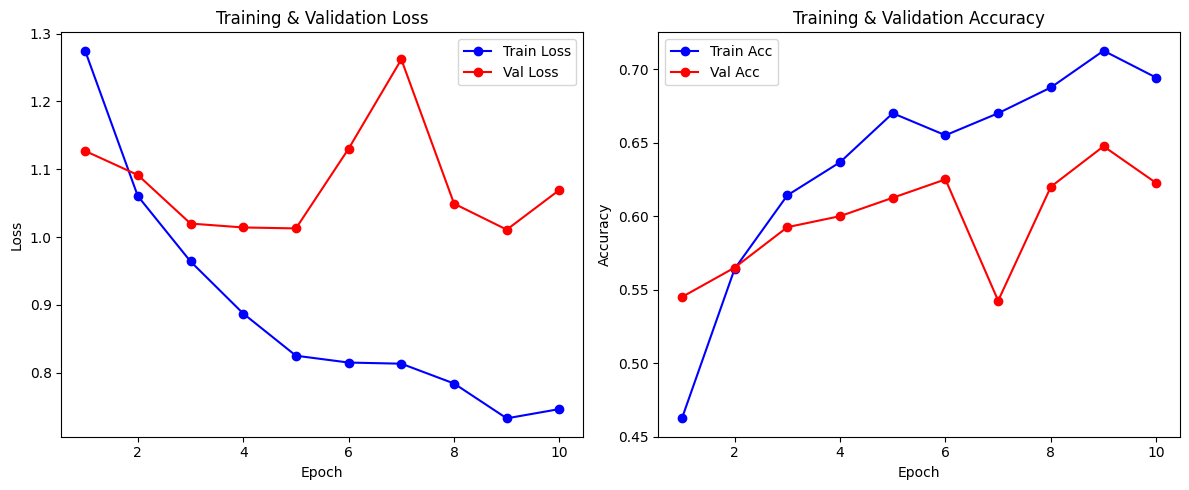

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



Grad-CAM visualization saved to: ./gradcam_visuals/gradcam_example_label_4.png

Individual Model Kappas: Model1=0.5425, Model2=0.5425
Ensemble Kappa (MaxVote): 0.5425
Ensemble Kappa (Weighted): 0.5425
Ensemble Kappa (Stacking): 0.5548

Done.


In [6]:
# Transforms
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# val_test_transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# ===================================

# # ===================================
# # ===== ENSEMBLE & PREDICTIONS ======
# # ===================================
# def predict_model(model, loader):
#     """
#     Return (preds, probs) for each sample:
#       preds: [num_samples, ] (class indices)
#       probs: [num_samples, num_classes]
#     """
#     model.eval()
#     all_preds = []
#     all_probs = []

#     with torch.no_grad():
#         for inputs, _ in loader:
#             inputs = inputs.to(device)
#             outputs = model(inputs)
#             prob = F.softmax(outputs, dim=1)
#             preds = torch.argmax(prob, dim=1)

#             all_preds.extend(preds.cpu().numpy())
#             all_probs.extend(prob.cpu().numpy())
#     return np.array(all_preds), np.array(all_probs)

# def ensemble_max_voting(predictions_list):
#     """
#     predictions_list: list of shape [num_samples], from multiple models
#     Return final predictions by majority vote.
#     """
#     stacked = np.stack(predictions_list, axis=0)  # (num_models, num_samples)
#     final_preds = []
#     for i in range(stacked.shape[1]):
#         vals, counts = np.unique(stacked[:, i], return_counts=True)
#         final_preds.append(vals[np.argmax(counts)])
#     return np.array(final_preds)

# def ensemble_weighted_average(proba_list, weights=None):
#     """
#     proba_list: list of shape [num_samples, num_classes]
#     weights: optional list of floats, same length as proba_list
#     """
#     if weights is None:
#         weights = [1.0]*len(proba_list)
#     wsum = np.zeros_like(proba_list[0])
#     for p, w in zip(proba_list, weights):
#         wsum += p*w
#     wsum /= sum(weights)
#     return np.argmax(wsum, axis=1)

# def ensemble_bagging(predictions_list):
#     """
#     Basic bagging approach with majority vote.
#     """
#     return ensemble_max_voting(predictions_list)

# def ensemble_stacking(proba_list, labels_val=None):
#     """
#     Train a meta-learner (LogisticRegression) on stacked probabilities.
#     """
#     X_stack = np.hstack(proba_list)  # (num_samples, num_models * num_classes)
#     if labels_val is None:
#         print("No labels -> fallback to Weighted Average.")
#         return ensemble_weighted_average(proba_list)
    
#     meta_clf = LogisticRegression()
#     meta_clf.fit(X_stack, labels_val)
#     preds_meta = meta_clf.predict(X_stack)
#     return preds_meta

# ===================================

# ===================================
# =============== MAIN ==============
# ===================================
    # ---------------------------------------------------------
    # Example: Train a ResNet18 on APTOS, log accuracy & Kappa
    # ---------------------------------------------------------
    # train_ds = DiabeticRetinopathyDataset(TRAIN_CSV_APTOS, TRAIN_IMG_DIR_APTOS, transform=train_transform)
    # val_ds   = DiabeticRetinopathyDataset(VAL_CSV_APTOS,   VAL_IMG_DIR_APTOS,   transform=val_test_transform)
    # train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
    # val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)

import cv2  # For Grad-CAM heatmap overlay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score

# Where to save Grad-CAM output
GRADCAM_OUTPUT_DIR = "./gradcam_visuals"
os.makedirs(GRADCAM_OUTPUT_DIR, exist_ok=True)


# =========== MODEL DEF =============
def get_resnet18(num_classes=5, pretrained=True):
    model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

# Example of other models if needed:
def get_resnet34(num_classes=5, pretrained=True):
    model = models.resnet34(weights='IMAGENET1K_V1' if pretrained else None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

def get_densenet121(num_classes=5, pretrained=True):
    model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    return model

# ======== TRAINING FUNCTION ========
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, save_path=None):
    """
    Train the model. Track train/val loss, accuracy, and Kappa each epoch.
    We'll save the best model based on *highest validation Kappa*.
    
    Returns:
      model (nn.Module) with best weights loaded
      history (dict) of training logs
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_kappa': [],
        'val_kappa': []
    }
    best_kappa = -1.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # --- Training ---
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []
        
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc  = accuracy_score(all_labels, all_preds)
        epoch_train_kappa= cohen_kappa_score(all_labels, all_preds)
        
        # --- Validation ---
        model.eval()
        running_val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc  = accuracy_score(val_labels, val_preds)
        epoch_val_kappa= cohen_kappa_score(val_labels, val_preds)
        
        # Store logs
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        history['train_kappa'].append(epoch_train_kappa)
        history['val_kappa'].append(epoch_val_kappa)
        
        print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Train Kappa: {epoch_train_kappa:.4f}")
        print(f"  Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc:.4f} | Val   Kappa: {epoch_val_kappa:.4f}")
        
        # Save best model based on Val Kappa
        if epoch_val_kappa > best_kappa:
            best_kappa = epoch_val_kappa
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"    -> Best model saved to {save_path} (val_kappa={best_kappa:.4f})")
    
    # After training, load best weights
    if save_path and os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    
    return model, history

# === PLOT TRAINING HISTORY (ACC) ===
def plot_training_history(history, save_path=None):
    """
    Plot the train/val loss and accuracy from the history dict.
    We also show Kappa if you like.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12,5))
    
    # ---- Loss ----
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # ---- Accuracy ----
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Val Acc')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# ============ GRAD-CAM =============
class GradCAM:
    """
    Grad-CAM for PyTorch model & target layer.
    """
    def __init__(self, model, target_layer_name="layer4"):
        self.model = model
        self.model.eval()
        # Find the target layer by name
        self.target_layer = dict(self.model.named_modules())[target_layer_name]
        
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.forward_hook = self.target_layer.register_forward_hook(self._forward_hook_fn)
        self.backward_hook = self.target_layer.register_backward_hook(self._backward_hook_fn)
    
    def _forward_hook_fn(self, module, inp, out):
        self.activations = out
    
    def _backward_hook_fn(self, module, grad_in, grad_out):
        # grad_out is a tuple
        self.gradients = grad_out[0]

    def generate_cam(self, input_tensor, class_idx=None):
        """
        Generates a Grad-CAM heatmap for a single image (input_tensor shape: [1, C, H, W]).
        class_idx: if None, uses model's predicted class.
        """
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()
        
        # gradients: [C, H, W], activations: [C, H, W]
        gradients = self.gradients[0].detach().cpu().numpy()
        activations = self.activations[0].detach().cpu().numpy()
    
        # Global average pool gradients
        weights = np.mean(gradients, axis=(1,2))
        
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i,:,:]
        
        cam = np.maximum(cam, 0)  # ReLU
        cam -= np.min(cam)
        cam /= (np.max(cam)+1e-8)
        return cam
    
    def remove_hooks(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

def apply_heatmap_on_image(img_tensor, heatmap):
    """
    Overlay heatmap on top of the original image.
    img_tensor: [C,H,W], normalized. heatmap: [H,W] in [0,1].
    """
    img_np = img_tensor.cpu().numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = std*img_np + mean
    img_np = np.clip(img_np, 0, 1)
    img_np = (img_np*255).astype(np.uint8)
    
    # Resize heatmap to match
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_colored = plt.cm.jet(heatmap_resized)[:,:,:3]
    heatmap_colored = (heatmap_colored*255).astype(np.uint8)
    
    alpha = 0.5
    overlay = cv2.addWeighted(img_np, alpha, heatmap_colored, 1-alpha, 0)
    
    return Image.fromarray(overlay)


if __name__ == "__main__":
    # Create DeepDRiD loaders
    train_dataset_dr = DiabeticRetinopathyDataset(train_csv_dr, train_img_dir_dr,
                                                  transform=train_transform)
    val_dataset_dr = DiabeticRetinopathyDataset(val_csv_dr, val_img_dir_dr,
                                                transform=val_test_transform)
    train_loader_dr = DataLoader(train_dataset_dr, batch_size=32, shuffle=True)
    val_loader_dr   = DataLoader(val_dataset_dr, batch_size=32, shuffle=False)
    
    model = get_resnet18(num_classes=5, pretrained=True).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    print("\n--- Training ResNet18 on APTOS (Tracking Accuracy & Kappa) ---")
    model, history = train_model(
        model,
        train_loader_dr,
        val_loader_dr,
        criterion,
        optimizer,
        num_epochs=epoch,  # Increase for better results
        save_path="best_aptos_model.pth"
    )
    
    # Plot training curves
    plot_training_history(history, save_path="train_history.png")
    
    # ---------------------------------------------------------
    # Grad-CAM example on a single validation image
    # ---------------------------------------------------------
    val_iter = iter(val_loader_dr)
    images, labels = next(val_iter)
    
    single_img = images[0].unsqueeze(0).to(device)  # shape [1,C,H,W]
    label = labels[0].item()
    
    gradcam = GradCAM(model, target_layer_name="layer4")
    heatmap = gradcam.generate_cam(single_img, class_idx=None)  # predicted class
    gradcam.remove_hooks()
    
    overlay = apply_heatmap_on_image(images[0], heatmap)
    save_path = os.path.join(GRADCAM_OUTPUT_DIR, f"gradcam_example_label_{label}.png")
    overlay.save(save_path)
    print(f"\nGrad-CAM visualization saved to: {save_path}")
    
    # ---------------------------------------------------------
    # (Optional) Ensemble demonstration
    #   1) Suppose we train multiple models (resnet18, resnet34)
    #   2) We gather predictions on val set
    #   3) Combine via ensemble
    # ---------------------------------------------------------
    # For brevity, let's pretend we have a second model trained:
    model2 = get_resnet34(num_classes=5, pretrained=True).to(device)
    # ... train model2 similarly ...
    # Skipping for brevity: model2, history2 = train_model(...)
    
    # We'll just do a dummy demonstration of ensemble:
    #  - We'll assume model2 is identical in predictions
    preds1, probs1 = predict_model(model, val_loader_dr)
    preds2, probs2 = predict_model(model, val_loader_dr)  # Just using model again for example

    # Collect ground truth for val set
    val_labels_all = []
    for _, lbls in val_loader_dr:
        val_labels_all.extend(lbls.numpy())
    val_labels_all = np.array(val_labels_all)

    # Evaluate each model individually
    kappa1 = cohen_kappa_score(val_labels_all, preds1)
    kappa2 = cohen_kappa_score(val_labels_all, preds2)
    print(f"\nIndividual Model Kappas: Model1={kappa1:.4f}, Model2={kappa2:.4f}")

    # Ensemble
    preds_list = [preds1, preds2]
    probs_list = [probs1, probs2]

    # (A) Max voting
    preds_maxvote = ensemble_max_voting(preds_list)
    kappa_maxvote = cohen_kappa_score(val_labels_all, preds_maxvote)

    # (B) Weighted average
    preds_weighted = ensemble_weighted_average(probs_list, weights=[0.7, 0.3])
    kappa_weighted = cohen_kappa_score(val_labels_all, preds_weighted)

    # (C) Stacking
    preds_stacking = ensemble_stacking(probs_list, labels_val=val_labels_all)
    kappa_stacking = cohen_kappa_score(val_labels_all, preds_stacking)

    print(f"Ensemble Kappa (MaxVote): {kappa_maxvote:.4f}")
    print(f"Ensemble Kappa (Weighted): {kappa_weighted:.4f}")
    print(f"Ensemble Kappa (Stacking): {kappa_stacking:.4f}")

    print("\nDone.")